In [ ]:
## Key findings: 
- There are great gaps in the data
- The timeline is too short to assume any seasonalities
- A simple Outlier detection using z-scores identified datapoints with heating_temperature < 23 Degrees as outliers
- This should be validated by more complex models with more data points. 


using:
pandas version 2.0.3
matplotlib version 3.7.2

DATA IMPORT:
                               datetime        property_name  temperature
source_id                                                                
MICDEV001  2019-04-13T17:51:16.000+0000  heating_temperature         33.3
MICDEV001  2019-04-13T17:51:16.000+0000  cooling_temperature         15.0
MICDEV001  2019-04-13T18:51:18.000+0000  heating_temperature         34.0
MICDEV001  2019-04-13T19:51:20.000+0000  heating_temperature         33.8
MICDEV001  2019-04-13T20:51:21.000+0000  heating_temperature         34.2

----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, MICDEV001 to MICDEV001
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       1000 non-null   object 
 1   property_name  1000 non-null   object 
 2   temperature    1000 non-null   float64
dtypes: float64(1), o

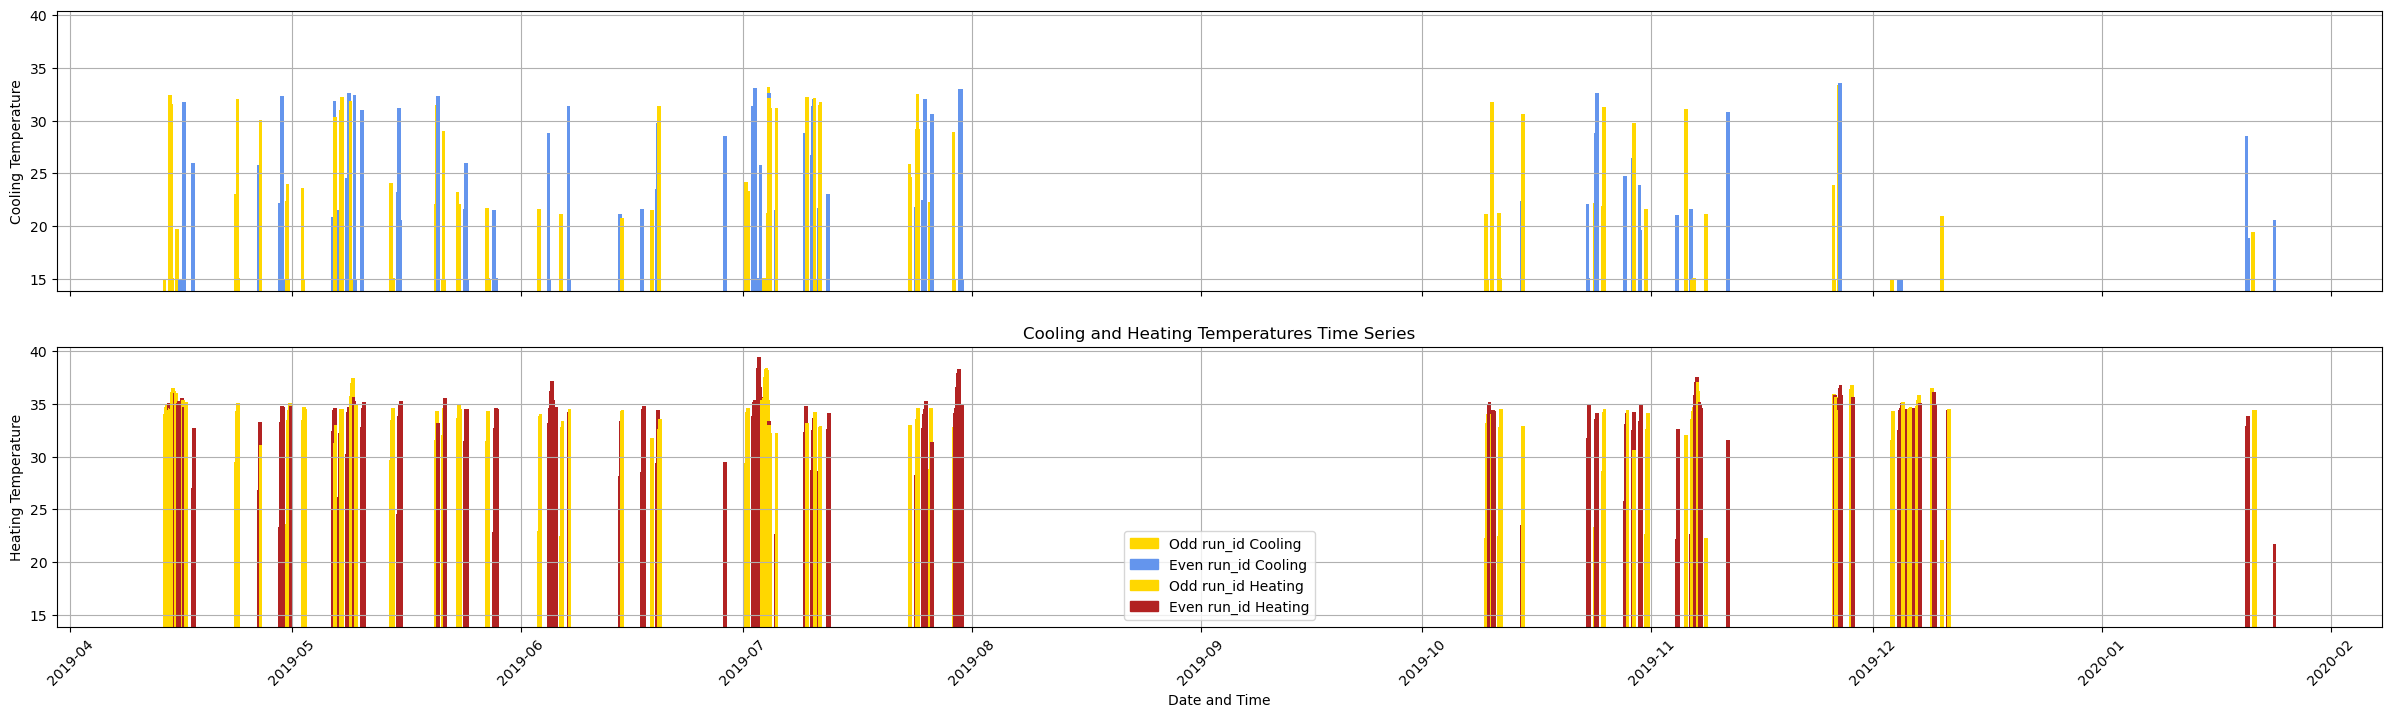


DESCRIPTIVE STATS:
 property_name  cooling_temperature  heating_temperature     unix_time  \
count                   301.000000           699.000000  7.160000e+02   
mean                     21.295681            33.075393  1.563845e+09   
std                       6.763378             3.363579  7.105323e+06   
min                      14.900000            21.700000  1.555178e+09   
25%                      15.000000            32.500000  1.557835e+09   
50%                      20.800000            34.200000  1.562143e+09   
75%                      28.500000            34.800000  1.571841e+09   
max                      33.600000            39.400000  1.579856e+09   

property_name      run_id  
count          716.000000  
mean            55.627095  
std             32.823483  
min              1.000000  
25%             29.000000  
50%             52.000000  
75%             80.000000  
max            122.000000  


/tmp/ipykernel_301/330008748.py:172: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  z_scores = (self.dataframe - self.mean) / self.std_dev
/tmp/ipykernel_301/330008748.py:178: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  z_scores = (self.dataframe - self.mean) / self.std_dev


NameError: name 'column_names_with_anomalies' is not defined

In [24]:
from platform import python_version
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import uuid

print('using:')
print('pandas version', pd.__version__)
print('matplotlib version', matplotlib.__version__)
print('python_version', python_version())

class TemperatureDataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df_ts = None

    def import_data(self):
        """Import temperature data from a CSV file. Print a summary and info of the imported DataFrame."""
        self.df_ts = pd.read_csv(self.file_path, header=0, index_col=0, parse_dates=True)
        print('\nDATA IMPORT:')
        print(self.df_ts.head())
        print('')
        print('----------------------------------------------------------')
        print(self.df_ts.info())
        print('')

    def clean_data(self):
        """Ensure data integrity by removing duplicates and converting datetime column from object to date."""
        if self.df_ts is not None:
            self.df_ts = self.df_ts.drop_duplicates()
            self.df_ts['datetime'] = pd.to_datetime(self.df_ts['datetime'])  # Convert to datetime format

    def pivot_data(self):
        """Pivot the DataFrame by heating and cooling temperature."""
        if self.df_ts is not None:
            df_pivot = self.df_ts.pivot(index='datetime', columns='property_name', values='temperature')
            df_pivot = df_pivot[['cooling_temperature', 'heating_temperature']]
            df_pivot.reset_index(inplace=True)
            print('\nPIVOTED DATAFRAME:')
            print(df_pivot.head())
            print('')
            print('----------------------------------------------------------')
            print(df_pivot.info())
            print('')
            return df_pivot

    def add_run_id(self, df_pivot):
        """Adds columns 'unix_time' and 'run_id' to df_pivot based on specified conditions.
        Looking at the timegap, it is visible that often the gap between datapoints is about 1 hour. 
        It can be assumed that while the machine is running, the signals are sent every hour. 
        Therefore, a sequence of signals will have the same run_id if the time gap between them is around that size. 
        """
        if df_pivot is not None:
            df_pivot.sort_values(by='datetime', inplace=True)  # Sort by datetime
            # Convert datetime column to Unix timestamps
            df_pivot['unix_time'] = df_pivot['datetime'].astype(int) / 10**9  # Convert nanoseconds to seconds
            
            run_id = 0
            last_datetime = None
            for index, row in df_pivot.iterrows():
                if last_datetime is None or (row['unix_time'] - last_datetime) > 3720.0:
                    run_id += 1
                df_pivot.at[index, 'run_id'] = run_id
                last_datetime = row['unix_time']
            print('\nPIVOTED DATAFRAME WITH RUN IDs:')
            print(df_pivot.head())
            print('')
            print('----------------------------------------------------------')
            print(df_pivot.info())
            print('')


    def plot_temperature(self, df_pivot, save_as_png=False):
        """Plot cooling and heating temperatures as a time series.
        Color the bars in alternating colors depending on run id 
        The goal here is to visually detect a pattern in the way the machine is sendning signals.
        In reals life, I would try to get expertise insights from an expert who knows this machine and why it is sending the data in this way.

        Set save_as_png to True if you want the image saved in a larger size for more detailed exploration. 
        A random UUID will be added to the filename.
        
        """
        
        figsize = (30, 8)
        
        if save_as_png: 
            figsize = (120, 12)
        fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

        # Get unique run IDs
        unique_run_ids = df_pivot['run_id'].unique()

        # Define colors for even and odd run IDs
        even_color_heating = 'firebrick'
        even_color_cooling = 'cornflowerblue'
        odd_color = 'gold'

        # Create a dictionary to store distinct legend labels and colors
        legend_labels = {}
        
        # Plot cooling temperature with alternating colors by run_id
        for run_id in unique_run_ids:
            df_run = df_pivot[df_pivot['run_id'] == run_id]
            color = even_color_cooling if run_id % 2 == 0 else odd_color
            label = 'Even run_id Cooling' if run_id % 2 == 0 else 'Odd run_id Cooling'
            if label not in legend_labels:
                legend_labels[label] = color
                axes[0].bar(df_run['datetime'], df_run['cooling_temperature'], color=color, width=0.5, label=label)
            else:
                axes[0].bar(df_run['datetime'], df_run['cooling_temperature'], color=color, width=0.5)

        axes[0].set_ylabel('Cooling Temperature')
        axes[0].grid(True)

        # Plot heating temperature with alternating colors by run_id
        for run_id in unique_run_ids:
            df_run = df_pivot[df_pivot['run_id'] == run_id]
            color = even_color_heating if run_id % 2 == 0 else odd_color
            label = 'Even run_id Heating' if run_id % 2 == 0 else 'Odd run_id Heating'
            if label not in legend_labels:
                legend_labels[label] = color
                axes[1].bar(df_run['datetime'], df_run['heating_temperature'], color=color, width=0.5, label=label)
            else:
                axes[1].bar(df_run['datetime'], df_run['heating_temperature'], color=color, width=0.5)

        axes[1].set_ylabel('Heating Temperature')
        axes[1].grid(True)

        # Create a legend with distinct labels and colors
        handles = [plt.Rectangle((0,0),1,1, color=color) for label, color in legend_labels.items()]
        labels = [label for label, _ in legend_labels.items()]
        axes[1].legend(handles, labels, loc='best')

        # Set y-axis limits to ensure same range for both subplots
        min_temp = min(df_pivot[['cooling_temperature', 'heating_temperature']].min())
        max_temp = max(df_pivot[['cooling_temperature', 'heating_temperature']].max())
        for ax in axes:
            ax.set_ylim(min_temp - 1, max_temp + 1)

        # Formatting the plot
        plt.xlabel('Date and Time')
        plt.title('Cooling and Heating Temperatures Time Series')

        # Rotating x-axis labels for better visibility
        plt.xticks(rotation=45)

        
        if save_as_png: 
            # Generate a UUID
            random_id = uuid.uuid4()  # Generate a random UUID
            
            # Convert UUID to string and construct the plot filename
            plot_filename = f'ts_chart_{random_id}.png'
    
            # Save the plot to the constructed filename
            plt.savefig(plot_filename)

        # Displaying the plot
        plt.show()


class SimpleAnomalyDetector:
    def __init__(self, dataframe, threshold=3):
        self.dataframe = dataframe
        self.descriptive_stats = self.dataframe.describe()
        self.mean = self.dataframe.mean()
        self.std_dev = self.dataframe.std()
        self.threshold = threshold
    
    def detect_anomalies(self):
        """
        Basic Anomaly detection based on Z-scores; threshold is set in class intitalization
        """
        z_scores = (self.dataframe - self.mean) / self.std_dev
        anomalies = (z_scores > self.threshold) | (z_scores < -self.threshold)
        
        return self.dataframe[anomalies.any(axis=1)]

    def column_names_with_anomalies(self):
        z_scores = (self.dataframe - self.mean) / self.std_dev
        anomalies = (z_scores > self.threshold) | (z_scores < -self.threshold)
        anomalous_columns = {}
        for col in df_pivot.columns:
            if any(anomalies[col]):
                anomalous_columns[col] = df_pivot[col][anomalies[col]]
        
        return anomalous_columns

# Initialize Data Processor, Import and clean data
processor = TemperatureDataProcessor('sample_temperature_data_for_coding_challenge.csv')
processor.import_data()
processor.clean_data()
df_pivot = processor.pivot_data()
processor.add_run_id(df_pivot)
processor.plot_temperature(df_pivot, save_as_png=False)


# there is a great gap in the timeseries data
# data is available between April and July (4 months) and then between October and beginning of December (2.5 months)
# In reality, I would consult with an expert for the machine to understand at what time is running
# Here, I assume that the machine is turned off and on as needed and sends signals every hour; 
# therefore I added the run ids as explained in the function "add_run_id()"

# Also, in the 716 rows, we don't always have both heating and cooling temperatures. 
# In most cases (699 rows) we have the heating temperature
# In only 301 rows, we also have cooling temperature
# This would also something I'd ask the machine expert about. 
# A general knowledge of what the machine does would be helpful to understand where to look for anomalies. 


# Due to the large data gaps and lack of knowledge about the data, it is not easy to detect anomalies. 
# I will try a simple anomaly detector based on the 6-Sigma principle:
# Create an instance of the AnomalyDetector class
threshold = 3
anomaly_detector = SimpleAnomalyDetector(df_pivot, threshold)

# Get descriptive statistics
print('\nDESCRIPTIVE STATS:\n',anomaly_detector.descriptive_stats)

anomalies = anomaly_detector.detect_anomalies()
anomaly_cols = anomaly_detector.column_names_with_anomalies()

print('\COLUMN VALUES OF ANOMALIES WITH THRESHOLD', threshold,':\n', column_names_with_anomalies)

print('\nWHOLEDATAFRAME WITH ANOMALIES', threshold,':\n', anomalies)

# For Threshold value = 3, it seems that there are no outliers for cooling temperature, but the heating temperature below 23 degrees seems to be outliers. 
# Variating the values for z threshhold leads to very different results; I would say that this is not necessarily the fitting method here. 